# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp311-cp311-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.
We are using a dataset of dogs of different breeds.

In [2]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip --no-check-certificate
!unzip dogImages.zip

--2025-03-18 18:17:51--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.220.136, 52.219.120.72, 52.219.121.112, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.220.136|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip.1’

dogImages.zip.1      17%[==>                 ] 191.79M  46.8MB/s    eta 22s    ^C
Archive:  dogImages.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of dogImages.zip or
        dogImages.zip.zip, and cannot find dogImages.zip.ZIP, period.


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [1]:
from PIL import Image
import os, random
from sagemaker.tuner import (
    IntegerParameter,
    ContinuousParameter,
    CategoricalParameter,
    HyperparameterTuner
)
from sagemaker.pytorch import PyTorch
from sagemaker.inputs import TrainingInput

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


022.Belgian_tervuren
(892, 663)


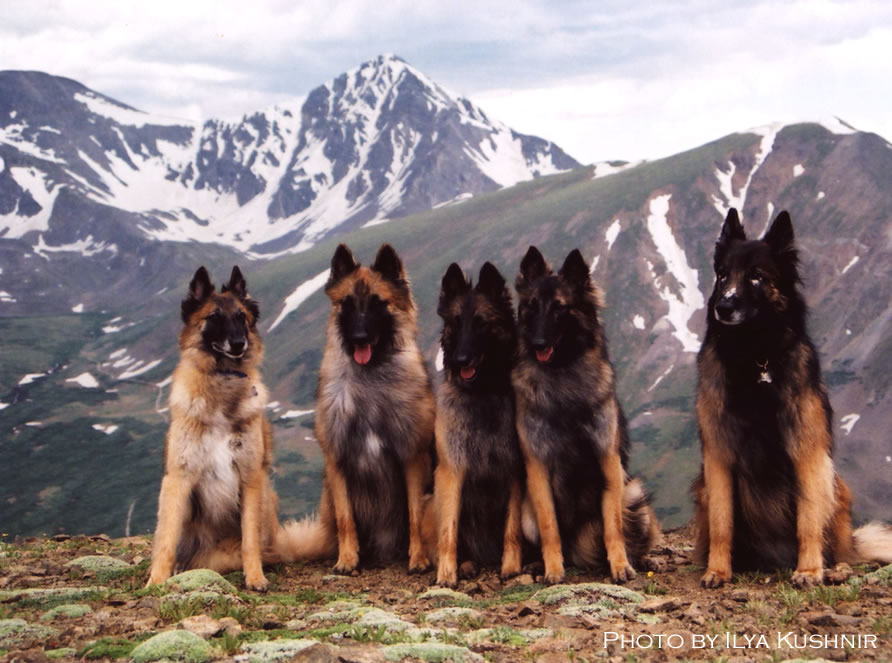

In [2]:
def show_random_image(folder: str = "train"):
    base_folder = f"dogImages/{folder}/"
    random_folder = random.choice(os.listdir(base_folder))
    random_file = random.choice(
        os.listdir(
            os.path.join(
                base_folder,
                random_folder
            )
        )
    )
    img = Image.open(os.path.join(base_folder, random_folder, random_file))
    print(random_folder)
    print(img.size)
    img.show()


show_random_image()

In [3]:
import sagemaker
sagemaker_session = sagemaker.Session()
BUCKET = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

In [4]:
local_dir = 'dogImages'
prefix = "dogImages"
input_folder = f"s3://{BUCKET}/{local_dir}"
output_folder = f"s3://{BUCKET}/output"
print(f"input spec (in this case, just an S3 path): {input_folder}")

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-394042569947/dogImages


In [7]:
train = sagemaker_session.upload_data(
    path="dogImages/train", bucket=BUCKET, key_prefix="train"
)
test = sagemaker_session.upload_data(
    path="dogImages/test", bucket=BUCKET, key_prefix="test"
)
valid = sagemaker_session.upload_data(
    path="dogImages/valid", bucket=BUCKET, key_prefix="valid"
)

In [69]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([16, 64])
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test Loss: ([+-]?[0-9\\.]+)"}]

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version='1.8',
    instance_count=1,
    instance_type='ml.g4dn.xlarge'
)

tuner = HyperparameterTuner(
    estimator=estimator,
    early_stopping_type="Auto",
    metric_definitions=metric_definitions,
    objective_metric_name=objective_metric_name,
    objective_type=objective_type,
    max_jobs=4,
    max_parallel_jobs=2,
    hyperparameter_ranges=hyperparameter_ranges
)

tuner.fit({"train": input_folder}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-250222-1714


...............................................................................................................................................................!


In [70]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

# Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2025-02-22 17:23:55 Starting - Preparing the instances for training
2025-02-22 17:23:55 Downloading - Downloading the training image
2025-02-22 17:23:55 Training - Training image download completed. Training in progress.
2025-02-22 17:23:55 Uploading - Uploading generated training model
2025-02-22 17:23:55 Completed - Resource reused by training job: pytorch-training-250222-1714-004-6172eb18


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"64"',
 'lr': '0.07443717364761436',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2025-02-22-17-14-48-458"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-394042569947/pytorch-training-2025-02-22-17-14-48-458/source/sourcedir.tar.gz"'}

In [77]:
best_hyperparameters = {
    "batch-size": int(best_estimator.hyperparameters()["batch-size"].replace('"', "")),
    "epochs": 1,
    "lr": best_estimator.hyperparameters()["lr"]
}

In [78]:
print(best_hyperparameters)

{'batch-size': 64, 'epochs': 1, 'lr': '0.07443717364761436'}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [7]:
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import (
    Rule, ProfilerRule, rule_configs,
    DebuggerHookConfig, ProfilerConfig,
    FrameworkProfile
)

objective_metric_name = "Test Accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "Test Accuracy", "Regex": "Test Accuracy: ([0-9\\.]+)"}]
best_hyperparameters = {'batch-size': 64, 'epochs': 15, 'lr': '0.07443717364761436'}


rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),  # Detect if loss is stagnant
    Rule.sagemaker(rule_configs.overfit()),  # Detect overfitting
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),  # Generate system profiling report
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile()
)

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "2", "eval.save_interval": "1"}
)

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="train_model.py",
    framework_version="1.6",
    py_version="py36",
    output_path=output_folder,
    hyperparameters=best_hyperparameters,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config,
    rules=rules
)

estimator.fit({"train": input_folder}, wait=True)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2025-03-18-18-29-50-889


2025-03-18 18:29:56 Starting - Starting the training job...
2025-03-18 18:30:21 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
Overfit: InProgress
ProfilerReport: InProgress
...
2025-03-18 18:30:41 Downloading - Downloading input data......
2025-03-18 18:31:51 Downloading - Downloading the training image......
2025-03-18 18:32:47 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-03-18 18:33:00,843 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-03-18 18:33:00,873 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-03-18 18:33:00,876 sagemaker_pytorch_container.training INFO     Invoking user training script.
2025-03-18 18:33:01,192 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_param

In [9]:
estimator.sagemaker_session.sagemaker_client.describe_training_job(
    TrainingJobName=estimator.latest_training_job.name
)

{'TrainingJobName': 'pytorch-training-2025-03-18-18-29-50-889',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:394042569947:training-job/pytorch-training-2025-03-18-18-29-50-889',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-394042569947/output/pytorch-training-2025-03-18-18-29-50-889/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch-size': '64',
  'epochs': '15',
  'lr': '"0.07443717364761436"',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"pytorch-training-2025-03-18-18-29-50-889"',
  'sagemaker_program': '"train_model.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-394042569947/pytorch-training-2025-03-18-18-29-50-889/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.6-gpu-py36',
  'TrainingInputMode': 'File',
  'EnableSageMakerMetri

In [10]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2025-03-18 18:49:44.122 default:173 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-03-18 18:49:44.136 default:173 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-394042569947/output/pytorch-training-2025-03-18-18-29-50-889/debug-output


INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


In [11]:
trial.tensor_names()

[2025-03-18 18:49:47.604 default:173 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2025-03-18 18:49:48.621 default:173 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0']

In [12]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

3

In [13]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

1

In [14]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [15]:
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


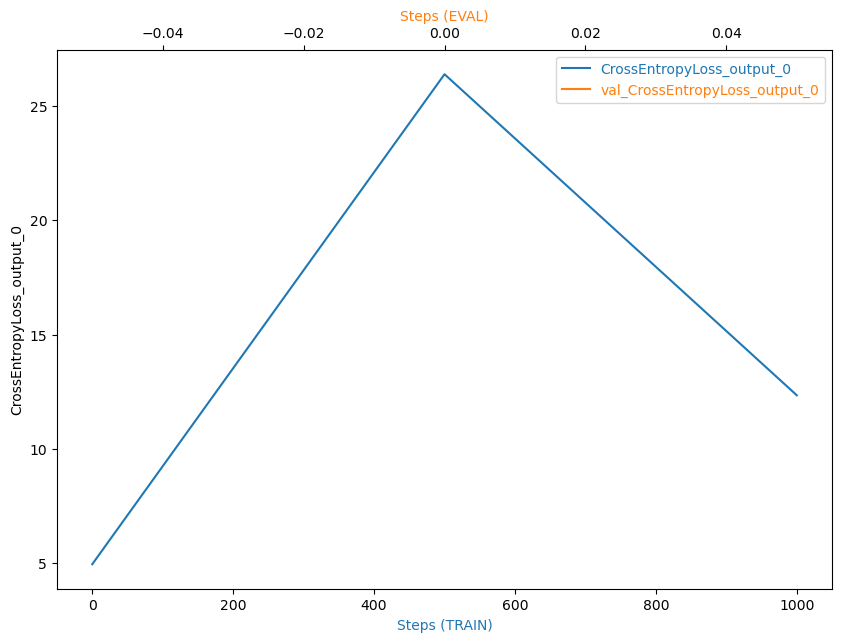

In [16]:
plot_tensor(trial, 'CrossEntropyLoss_output_0')

In [17]:
rule_output_path = f"{estimator.output_path}/{estimator.latest_training_job.job_name}/rule-output"
print(rule_output_path)

s3://sagemaker-us-east-1-394042569947/output/pytorch-training-2025-03-18-18-29-50-889/rule-output


In [18]:
! aws s3 ls {rule_output_path} --recursive

2025-03-18 18:48:57     408149 output/pytorch-training-2025-03-18-18-29-50-889/rule-output/ProfilerReport/profiler-output/profiler-report.html
2025-03-18 18:48:57     261906 output/pytorch-training-2025-03-18-18-29-50-889/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2025-03-18 18:48:52        192 output/pytorch-training-2025-03-18-18-29-50-889/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2025-03-18 18:48:52      36659 output/pytorch-training-2025-03-18-18-29-50-889/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2025-03-18 18:48:52        126 output/pytorch-training-2025-03-18-18-29-50-889/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2025-03-18 18:48:52        329 output/pytorch-training-2025-03-18-18-29-50-889/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2025-03-18 18:48:52        830 output/pytorch-training-2025-03-18-18-29-50-889/rule-

In [19]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-394042569947/output/pytorch-training-2025-03-18-18-29-50-889/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-394042569947/output/pytorch-training-2025-03-18-18-29-50-889/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-394042569947/output/pytorch-training-2025-03-18-18-29-50-889/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-394042569947/output/pytorch-training-2025-03-18-18-29-50-889/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-394042569947/output/pytor

In [20]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [21]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:394042569947:processing-job/pytorch-training-2025-03-1-LossNotDecreasing-3d6df608',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2025, 3, 18, 18, 50, 5, 57000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overfit',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:394042569947:processing-job/pytorch-training-2025-03-1-Overfit-1fecd1b8',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2025, 3, 18, 18, 50, 5, 57000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'ProfilerReport',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:394042569947:processing-job/pytorch-training-2025-03-1-ProfilerReport-a09b26f8',
  'RuleEvaluationStatus': 'IssuesFound',
  'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule ProfilerReport at step 18 resulted in the condition being met\n',
  'LastModifiedTime

In [22]:
import IPython
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

## Model Deploying

In [6]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

model_data = f"{estimator.output_path}/{estimator.latest_training_job.job_name}/output/model.tar.gz"
print(f"Model: {model_data}")

# model_data = "s3://sagemaker-us-east-1-394042569947/output/pytorch-training-2025-03-18-18-29-50-889/output/model.tar.gz"
# Model: s3://sagemaker-us-east-1-394042569947/output/pytorch-training-2025-03-18-18-29-50-889/output/model.tar.gz

In [8]:
inference_model = PyTorchModel(
    model_data=model_data,
    role=role,
    entry_point='inference.py',
    py_version="py36",
    framework_version="1.6"
)

predictor = inference_model.deploy(
    initial_instance_count=1,
    # instance_type="ml.g4dn.xlarge"
    instance_type="ml.m5.large"
)

------!

In [9]:
# import io
# from PIL import Image
# image = Image.open(img_loc)
# print(type(image))
# buffer = io.BytesIO()
# image.save(buffer, format="PNG")
# image_bytes = buffer.getvalue()
# print(type(image_bytes))
# response = predictor.predict(image_bytes)
# print("Predicted digit:", response)
# print(f"class: {img_loc}, pred: {response}")

In [10]:
# import io
# from PIL import Image
# image = Image.open(img_loc)
# buffer = io.BytesIO()
# image.save(buffer, format="PNG")
# image_bytes = buffer.getvalue()

# import boto3

# endpoint_name = "pytorch-inference-2025-03-18-18-53-28-010"
# runtime = boto3.client("sagemaker-runtime")

# # Load image in binary mode
# with open(img_loc, "rb") as img_file:
#     image_bytes = img_file.read()

# # Invoke endpoint
# response = runtime.invoke_endpoint(
#     EndpointName=endpoint_name,
#     ContentType="image/jpeg",
#     Body=image_bytes
# )

In [11]:
# response

In [9]:
def get_random_image(folder: str = "test"):
    base_folder = f"dogImages/{folder}/"
    random_folder = random.choice(os.listdir(base_folder))
    random_file = random.choice(
        os.listdir(
            os.path.join(
                base_folder,
                random_folder
            )
        )
    )
    return os.path.join(base_folder, random_folder, random_file)


def show_image(loc: str):
    img = Image.open(loc)
    # print(random_folder)
    # print(img.size)
    img.show()

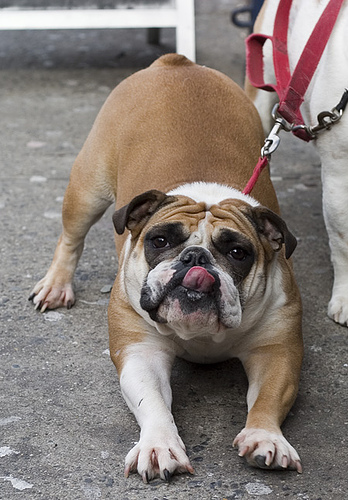

In [10]:
img_loc = get_random_image(folder='test')
show_image(img_loc)

In [14]:
with open(img_loc, 'rb') as f:
    image = f.read()

response = predictor.predict(image)
print("prediction: ", np.argmax(response) + 1)
print("actual class: ", img_loc)

prediction:  40
actual class:  dogImages/test/040.Bulldog/Bulldog_02817.jpg


In [80]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-training-2025-03-12-23-18-43-529
INFO:sagemaker:Deleting endpoint with name: pytorch-training-2025-03-12-23-18-43-529
